In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.models.DCVC_net import DCVC_net
import torch
from torchvision import transforms
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import wandb
import tqdm

/home/jatin/miniconda3/envs/DCVC/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
LAMBDA = 2048
BATCH_SIZE = 4
DATA_DIR = pathlib.Path('/data2/jatin/vimeo_septuplet/sequences')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [4]:
exp_name = f'b_frame_lamba={LAMBDA}-old-continue'

In [5]:
wandb.init(
    project="DCVC-B-frames", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "DCVC",
    "dataset": "UVG",
    "epochs": 20,
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: codec-crew (use `wandb login --relogin` to force relogin)


In [6]:
video_net = DCVC_net(up_strategy='default')

In [14]:
# load the good weights
# video_net.opticFlow = torch.load('../DCVC/optflow.pth')
# video_net.mvEncoder = torch.load('../DCVC/mvenc.pth')
# video_net.mvDecoder_part1 = torch.load('../DCVC/mvDecoder_part1.pth')
# video_net.mvDecoder_part2 = torch.load('../DCVC/mvDecoder_part2.pth')
# video_net.feature_extract = torch.load('../DCVC/feature_extract.pth')
# video_net.context_refine = torch.load('../DCVC/context_refine.pth')
# video_net.contextualDecoder_part1 = torch.load('../DCVC/contextualDecoder_part1.pth')

# these keys do not match, so we remove it from the network and add it back later
# temporalPriorEncoder = video_net.temporalPriorEncoder
# del video_net.temporalPriorEncoder

chpt = torch.load('dcvc-b-frame-with-bitrate-lambda-2048-tryfix-bitrate/dcvc_epoch=2_int_allquantize.pt')
video_net.load_state_dict(chpt['model'], strict=True)

video_net = video_net.to(DEVICE)

optimizer = torch.optim.Adam(video_net.parameters(), lr=wandb.config.learning_rate)
optimizer.load_state_dict(chpt['optimizer'])

# video_net.opticFlow.requires_grad_ = False
# video_net.mvEncoder.requires_grad_ = False
# video_net.mvDecoder_part1.requires_grad_ = False
# video_net.mvDecoder_part2.requires_grad_ = False
# video_net.feature_extract.requires_grad_ = False
# video_net.context_refine.requires_grad_ = False
# video_net.contextualDecoder_part1.requires_grad_ = False

del chpt

In [15]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, crop_size=256, make_b_cut=True, deterministic=False):
        self.data_dir = data_dir
        self.crop_size = crop_size
        self.make_b_cut = make_b_cut
        self.deterministic = deterministic
        self.all_paths = []
        for seq in os.listdir(self.data_dir):
            subseq = os.listdir(self.data_dir / seq)
            for s in subseq:
                self.all_paths.append(self.data_dir / seq / s)
        assert len(self.all_paths) == 91701
        
        self.transforms = torch.nn.Sequential(
            transforms.RandomCrop(crop_size)
        )
       
    def __getitem__(self, i):
        path = self.all_paths[i]
        imgs = []
        if self.make_b_cut:
            # load two reference frames and the B-frame in the middle
            #TODO: implement making this deterministic
            interval = np.random.randint(1, 4) # can be 1, 2, or 3
            ref1 = plt.imread(path / f'im{1}.png')
            ref2 = plt.imread(path / f'im{1 + interval*2}.png')
            # this is the B-frame, in the middle
            im = plt.imread(path / f'im{1 + interval}.png')
            imgs = [ref1, ref2, im]
        else:
            # load full sequence
            for i in range(1, 8):
                # should be between [0, 1]
                img = plt.imread(path / f'im{i}.png')
        
        # plt.imread should make inputs in [0, 1] for us
        imgs = np.stack(imgs, axis=0)
        # bring RGB channels in front
        imgs = imgs.transpose(0, 3, 1, 2)
        return self.transforms(torch.FloatTensor(imgs))

    def __len__(self):
        return len(self.all_paths)

ds = VideoDataset(DATA_DIR)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=6,
    prefetch_factor=5
)

In [16]:
criterion = torch.nn.MSELoss()

In [17]:
def count_parameters(model):
    """Return number of parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(video_net)} trainable parameters')

The model has 10622976 trainable parameters


In [18]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_mse = 0
    epoch_bitrate = 0
    total_count = 0
    avg_mse_loss = float('inf')
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, x in enumerate(pbar):
        x = x.to(DEVICE)
        ref1 = x[:,0]
        ref2 = x[:,1]
        im = x[:,2]
        preds_dict = model(ref1, ref2, im, compress_type='train_compress')
        preds = preds_dict['recon_image']
        bpp = preds_dict['bpp']
        mse_loss = criterion(preds, im)
        mse_ls = mse_loss.item()
        if avg_mse_loss < 0.001 and mse_ls > 0.1:
            # waits until average loss is pretty low
            print('REALLY BAD LOSS', mse_ls)
            wandb.alert(
                title="High Loss", 
                text=f"Loss {mse_ls} is way above the threshold"
            )
            return None, True, x
        loss = mse_loss * LAMBDA + bpp
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        ls = loss.item()
        epoch_loss += ls
        epoch_mse += mse_ls
        epoch_bitrate += bpp.item()
        total_count += 1
        if i % 1 == 0:
            avg_loss = epoch_loss / total_count
            avg_mse_loss = epoch_mse / total_count
            avg_bitrate = epoch_bitrate / total_count
            avg_psnr = -10.0*np.log10(avg_mse_loss)
            wandb.log(
                {
                    'train/epoch': epoch,
                    'train/batch_loss': ls,
                    'train/avg_loss': avg_loss,
                    'train/avg_mse_loss': avg_mse_loss,
                    'train/avg_bitrate': avg_bitrate,
                    'train/avg_psnr': avg_psnr,
                }
            )
            ls = round(ls, 6)
            avg_bitrate = round(avg_bitrate, 6)
            avg_psnr = round(avg_psnr, 6)
            pbar.set_description(f'Avg PSNR/Bitrate, Batch Loss: {avg_psnr, avg_bitrate, ls}')
        # save every 
        if i % 4000 == 3999:
            print('Saving model with avg loss', avg_loss)
            torch.save(
                {'model': model.state_dict(), 'optimizer': optimizer.state_dict()},
                SAVE_FOLDER / f"dcvc_epoch={epoch}_batch_{i}_avg_loss={avg_loss}.pt",
            )

    return avg_loss, False, None
            

In [19]:
SAVE_FOLDER = pathlib.Path(exp_name)
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [20]:
for i in range(1, wandb.config.epochs + 1):
    avg_loss, had_err, err_x = train_epoch(video_net, i, dl, optimizer, criterion)
    if had_err:
        print('Breaking out of train loop for debugging...')
        break
    torch.save(
        {'model': video_net.state_dict(), 'optimizer': optimizer.state_dict()},
        SAVE_FOLDER / f"dcvc_epoch={i}_avg_loss={avg_loss}.pt",
    )
    

Avg PSNR/Bitrate, Batch Loss: (40.116021, 0.140765, 0.380147):  17%|█▋        | 4000/22926 [32:44<2:50:56,  1.85it/s]

Saving model with avg loss 0.34016636303812264


Avg PSNR/Bitrate, Batch Loss: (40.150371, 0.139349, 0.709929):  33%|███▎      | 7580/22926 [1:02:02<2:06:11,  2.03it/s]wandb: Network error (ReadTimeout), entering retry loop.
Avg PSNR/Bitrate, Batch Loss: (40.15467, 0.139066, 0.184313):  35%|███▍      | 8000/22926 [1:05:28<2:15:18,  1.84it/s] 

Saving model with avg loss 0.3367008503600955


Avg PSNR/Bitrate, Batch Loss: (40.191247, 0.137465, 0.163045):  52%|█████▏    | 12000/22926 [1:38:12<1:38:53,  1.84it/s]

Saving model with avg loss 0.3334424983697633


Avg PSNR/Bitrate, Batch Loss: (40.152684, 0.137056, 0.320059):  70%|██████▉   | 16000/22926 [2:10:56<1:02:16,  1.85it/s]

Saving model with avg loss 0.3347805177792907


Avg PSNR/Bitrate, Batch Loss: (40.198895, 0.135686, 0.438025):  87%|████████▋ | 20000/22926 [2:43:39<26:02,  1.87it/s]  

Saving model with avg loss 0.33131798707321286


Avg PSNR/Bitrate, Batch Loss: (40.207213, 0.135212, 0.171575): 100%|██████████| 22926/22926 [3:07:36<00:00,  2.04it/s]
Avg PSNR/Bitrate, Batch Loss: (40.37334, 0.129129, 0.233738):  17%|█▋        | 4000/22926 [32:45<2:51:51,  1.84it/s] 

Saving model with avg loss 0.3170587160810828


Avg PSNR/Bitrate, Batch Loss: (40.380614, 0.127806, 0.423317):  35%|███▍      | 8000/22926 [1:05:30<2:14:18,  1.85it/s]

Saving model with avg loss 0.31542109748069197


Avg PSNR/Bitrate, Batch Loss: (40.379889, 0.127592, 0.326159):  37%|███▋      | 8507/22926 [1:09:39<1:58:02,  2.04it/s]wandb: Network error (ReadTimeout), entering retry loop.
Avg PSNR/Bitrate, Batch Loss: (40.381902, 0.127046, 0.314386):  52%|█████▏    | 12000/22926 [1:38:14<1:38:32,  1.85it/s]

Saving model with avg loss 0.31460606191058954


Avg PSNR/Bitrate, Batch Loss: (40.379404, 0.126994, 0.405825):  54%|█████▎    | 12289/22926 [1:40:36<1:27:20,  2.03it/s]wandb: Network error (ReadTimeout), entering retry loop.
Avg PSNR/Bitrate, Batch Loss: (40.399711, 0.126336, 0.399833):  70%|██████▉   | 16000/22926 [2:10:59<1:02:16,  1.85it/s]

Saving model with avg loss 0.3131282096300274


Avg PSNR/Bitrate, Batch Loss: (40.414944, 0.125532, 0.262255):  87%|████████▋ | 20000/22926 [2:43:44<26:23,  1.85it/s]  

Saving model with avg loss 0.3116700447246432


Avg PSNR/Bitrate, Batch Loss: (40.421677, 0.125334, 0.323922): 100%|██████████| 22926/22926 [3:07:41<00:00,  2.04it/s]
Avg PSNR/Bitrate, Batch Loss: (40.397273, 0.123621, 0.237853):  17%|█▋        | 4000/22926 [32:45<2:52:06,  1.83it/s]

Saving model with avg loss 0.3105184239465743


Avg PSNR/Bitrate, Batch Loss: (40.443903, 0.122298, 0.181481):  35%|███▍      | 8000/22926 [1:05:31<2:14:32,  1.85it/s]

Saving model with avg loss 0.3071988895377144


Avg PSNR/Bitrate, Batch Loss: (40.456748, 0.121935, 0.257167):  41%|████      | 9454/22926 [1:17:25<1:50:47,  2.03it/s]wandb: Network error (ReadTimeout), entering retry loop.
Avg PSNR/Bitrate, Batch Loss: (40.509739, 0.121008, 0.236134):  52%|█████▏    | 12000/22926 [1:38:16<1:39:12,  1.84it/s]

Saving model with avg loss 0.30312726021558045


Avg PSNR/Bitrate, Batch Loss: (40.502429, 0.121181, 0.239682):  70%|██████▉   | 16000/22926 [2:11:01<1:02:28,  1.85it/s]

Saving model with avg loss 0.30360706728091463


Avg PSNR/Bitrate, Batch Loss: (40.504049, 0.121178, 0.260034):  70%|███████   | 16112/22926 [2:11:56<55:40,  2.04it/s]  wandb: Network error (ReadTimeout), entering retry loop.
Avg PSNR/Bitrate, Batch Loss: (40.509403, 0.120746, 0.293462):  87%|████████▋ | 20000/22926 [2:43:46<26:25,  1.84it/s]

Saving model with avg loss 0.3028793722845614


Avg PSNR/Bitrate, Batch Loss: (40.512924, 0.120571, 0.188794): 100%|██████████| 22926/22926 [3:07:43<00:00,  2.04it/s]
Avg PSNR/Bitrate, Batch Loss: (40.578564, 0.118345, 0.289926):  17%|█▋        | 4000/22926 [32:45<2:50:41,  1.85it/s]

Saving model with avg loss 0.2976011317744851


Avg PSNR/Bitrate, Batch Loss: (40.544664, 0.118341, 0.395809):  35%|███▍      | 8000/22926 [1:05:31<2:14:39,  1.85it/s]

Saving model with avg loss 0.2990021380232647


Avg PSNR/Bitrate, Batch Loss: (40.579073, 0.117844, 0.172154):  52%|█████▏    | 12000/22926 [1:38:16<1:38:41,  1.85it/s]

Saving model with avg loss 0.29707902680523696


Avg PSNR/Bitrate, Batch Loss: (40.574542, 0.117756, 0.214302):  70%|██████▉   | 16000/22926 [2:11:01<1:02:25,  1.85it/s]

Saving model with avg loss 0.2971781003586948


Avg PSNR/Bitrate, Batch Loss: (40.570586, 0.117622, 0.193758):  87%|████████▋ | 20000/22926 [2:43:46<26:16,  1.86it/s]  

Saving model with avg loss 0.297207576379925


Avg PSNR/Bitrate, Batch Loss: (40.577814, 0.117408, 0.29023): 100%|██████████| 22926/22926 [3:07:42<00:00,  2.04it/s] 
Avg PSNR/Bitrate, Batch Loss: (40.681004, 0.116213, 0.244274):  12%|█▏        | 2745/22926 [22:29<2:45:20,  2.03it/s]


KeyboardInterrupt: 

In [21]:
torch.save(
        {'model': video_net.state_dict(), 'optimizer': optimizer.state_dict()},
        SAVE_FOLDER / f"dcvc_epoch={i}_int.pt",
)

In [22]:
SAVE_FOLDER

PosixPath('b_frame_lamba=2048-old-continue')

In [16]:
preds_x_np = preds.detach().cpu().numpy()

In [17]:
preds_x_np.shape

(4, 3, 256, 256)

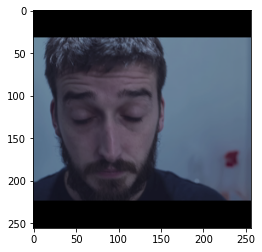

In [18]:
plt.imshow(np.clip(err_x_np[2,2].transpose(1,2,0), 0.0, 1.0))

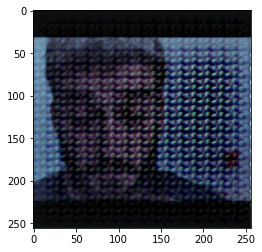

In [19]:
plt.imshow(np.clip(preds_x_np[2].transpose(1,2,0), 0.0, 1.0))

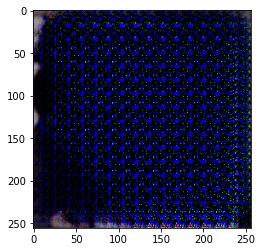

In [22]:
plt.imshow(np.clip(preds_x_np[2].transpose(1,2,0), 0.0, 1.0))

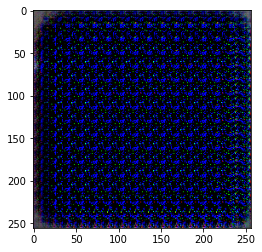

In [23]:
plt.imshow(np.clip(preds_x_np[3].transpose(1,2,0), 0.0, 1.0))

In [15]:
wandb.finish()

train/avg_bitrate,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/avg_loss,█▇▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/avg_mse_loss,██▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/avg_psnr,▁▁▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▇▇▇▇███▇████████
train/batch_loss,█▆▅▄▄▃▄▂▃▃▃▂▃▃▄▂▁▂▃▃▂▂▃▄▂▁▅▂▂▁▂▂▁▂▂▂▁▁▁▂
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
train/avg_bitrate,0.02835
train/avg_loss,0.12763
train/avg_mse_loss,5e-05
train/avg_psnr,43.14486
train/batch_loss,0.07535
